# Comparison of Landscan with GPWv4

Convert the Landscan data to 0.5x0.5˚ grid by summing up 60x60 sets of pixels. 

> NOTE data is delivered as ArcGIS .lyr file but QGIS seems to open it just fine, looks like GDAL should be able to do so also (might need to command line convert, not sure Rasterio will do it directly).

## Compare total population

We see quite a big difference between GPW and Landscan:

- Landscan 7.284273 Billion
- GPWv4 7.34932 Billion
- Difference 65.046619 Million

Both are within 'headline' figures found online (e.g. https://www.un.org/en/development/desa/publications/world-population-prospects-2015-revision.html) which give 7.3 Billion, i.e. both are correct to 1st decimal place but still leaves an uncertainty of 65 million.

It's an open question whether 65million is 'significant' - we know there is a lot of uncertainty in census data and the global population values are presumably given only to the nearest 100million for a reason. Question is what to do about it - can't just say the GPW data is the 'right' one just because we used it first. On the other hand, they probably do put more effort into cross checking and also the business with adjusting to match the UN WPP data (which means at least we should have agreement between the UN tables and the GPW grids).

It would be good to have UN WPP adjustments for Landscan data, would be intrested to see if it changes the delta. It might be possible to reproduce the NASA method for the Landscan data - we can use the nasa national identifier grids (should be also avaiable at the 30arcsecond resolution to avoid adding extra grid alignment problems). They might even already have a correction factor grid - otherwise it should be possible to calculate one. Quite a big hassle though...

## Compare population per pixel

Looking per-pixel, with find a very extreme max delta value of 3.861009 million, but that could be just some kind of alignment or numeric issue.

The 99th percentile is 209 378, 0.1th percentile is -214 139, so much smaller than the max suggesting that there is just a couple of one-off issues. 

These discrepencies still need to be looked into - I'm not too sure how at the moment. In theory the grids should match up perfectly because we have exatly the same number of cells. 

One possible issue is the cell alignment - the way I've rescaled Landscan means that the data point represents the top-left corder of a cell. Need to double check what the GPW data represents - in the Lancet calculations I anyway re-did the coordinate system and if I remember rightly I did actually do it properly i.e. made sure that if I change the coordinate this works correctly with the interpretation of the point being in the centre vs the corner of the grid cell. Something like - in the GPW it was the centre, but i changed the coordinates without changing the data, meaning that the point instead refers to the corner of the cell, but then the ERA data also refers to the corner of the cell so in the end we should be matching on the correct cell. Will have to have a think for the Landscan data but i think because I accumulated to the top left corner but then assigned the coordinates from GPW, the alignment should actually be correct (the coordinates refer to the centre of the cell).

The reason I'm thinking about grid alignment is that since we collect up a set of the fine points into one cell, in areas of very high density it could make a big difference which cell the input points get assigned to. Since we are on a faily coarse grid this does matter, could see issues with the weather causing instability in the results.

One idea is to go back to the reprojection approach (upsampling the weather to match the population). That approach was slow and annoything though, in the end you don't really change the grid alignment issue - either the alignment method is correct or it's not, the effects will in theory show up the same whether you downsample the population or upsample the weather. 

## Conclusions

> Not really any firm conclusions for now

- There's quite a big difference in the totals but it might be within the uncertainty range of global census data
- It would be good to see if we can apply UN WPP correction factors to Landscan, but that would be quite a lot of work
- There's quite a few differences at the pixel level, not clear to me why.

> NOTE/TODO: maybe compare the two datasets at the 30 arcsecond resolution so that we can at least decide whether its mainly a downsampling grid alignment issue.


In [1]:
%matplotlib inline

In [2]:
import numpy as np
import scipy as sp
import xarray as xr
import rasterio

import matplotlib.pyplot as plt

In [10]:
from config import POP_DATA_SRC, DATA_SRC


In [35]:
plt.rcParams['figure.dpi'] = 100

In [3]:
landscan_data_file = '~/Documents/ArcGIS/landscan2015.tif'
landscan_pop = xr.open_rasterio(landscan_data_file)

In [ ]:
dat = xr.open_dataarray(POP_DATA_SRC /'gpw_v4_une_atotpopbt_cntm_30_min.nc')
dat.name = 'population'
width = len(dat.longitude)

In [4]:
landscan_pop = landscan_pop.where(landscan_pop != landscan_pop.nodatavals)

In [7]:
out_rows = 360
out_cols = 720

stride = 60

In [5]:
landscan_dat = landscan_pop.squeeze().fillna(0).values

In [8]:
landscan_lowres = np.zeros( (out_rows, out_cols), dtype=np.int32 )
for i in range(out_rows):
    for j in range(out_cols):
        landscan_lowres[i,j] = np.nansum(landscan_dat[stride*i:stride*i+stride, stride*j:stride*j+stride])

In [41]:
dat = xr.open_dataarray(POP_DATA_SRC /'gpw_v4_une_atotpopbt_cntm_30_min.nc')
dat.name = 'population'
width = len(dat.longitude)

# Select only the 1st 5 rasters which correspond to the year counts
gpw_pop = dat.sel(raster=[1,2,3,4,5]).copy()

In [42]:
gpw_pop
gpw_pop['raster'] = 2000 + 5*(gpw_pop.raster-1)
gpw_pop = gpw_pop.rename({'raster':'year'})
gpw_pop['year'] = gpw_pop.year.astype(np.int32)

In [43]:
gpw_pop = gpw_pop.sel(year=2015,drop=True)

In [23]:
landscan_lowres_xr = xr.DataArray(landscan_lowres, coords=[np.arange(89.75,-90, -0.5),
                                      gpw_pop.longitude], dims=['latitude','longitude'])
                                     

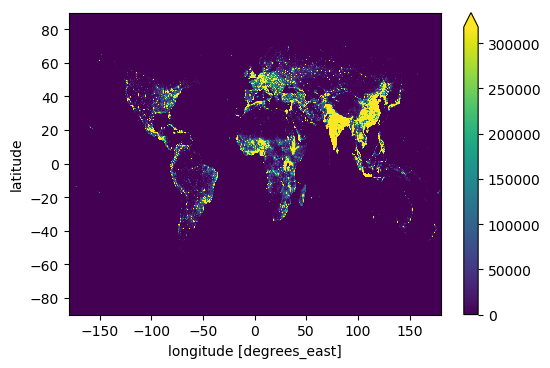

In [53]:
landscan_lowres_xr.plot(robust=True)

Compare the global totals between datasets

In [52]:
landscan_lowres_xr.sum() 

<xarray.DataArray ()>
array(7284273061)

In [49]:
gpw_pop.sum()

<xarray.DataArray 'population' ()>
array(7.34932e+09, dtype=float32)

In [50]:
landscan_lowres_xr.sum() - gpw_pop.sum()

<xarray.DataArray ()>
array(-65046619.)

In [46]:
gpw_pop.max()

<xarray.DataArray 'population' ()>
array(21081032.)

In [47]:
landscan_lowres_xr.max()

<xarray.DataArray ()>
array(20413639, dtype=int32)

In [25]:
delta  = gpw_pop - landscan_lowres_xr

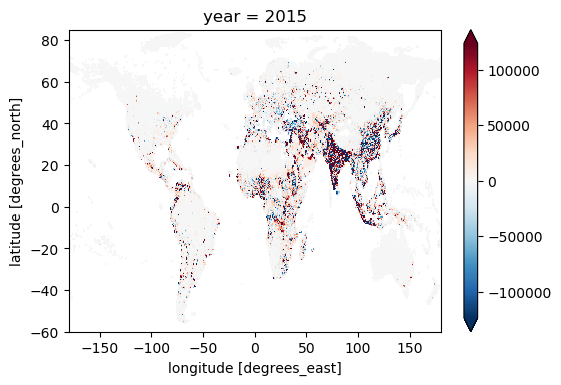

In [69]:
delta.plot(robust=True);

In [54]:
delta.max()

<xarray.DataArray ()>
array(3861009.)
Coordinates:
    year     int32 2015

In [58]:
delta.quantile([0.01, 0.99])

<xarray.DataArray (quantile: 2)>
array([-214139.059688,  209378.0525  ])
Coordinates:
  * quantile  (quantile) float64 0.01 0.99

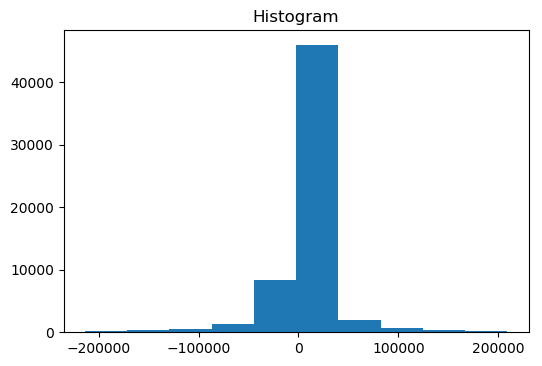

In [68]:
delta.plot.hist(range=delta.quantile([0.01, 0.99]).values.tolist());